In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from os.path import join

In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


In [3]:
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation

In [4]:
sns.set()

## Pre-processing 

Same as before

In [5]:
def data_preprocessing(path):
    features = pd.read_csv(path)
    features = features.drop(['year', 'weekofyear'],
                            axis = 1)
    features = features.drop(['reanalysis_sat_precip_amt_mm',
                              'reanalysis_tdtr_k'],
                            axis = 1)
    features = features.rename({'week_start_date': 'ds'}, axis = 1)
    features_sj = features[features['city'] == 'sj'].drop('city', axis = 1)
    features_iq = features[features['city'] == 'iq'].drop('city', axis = 1)
    return (features_sj, features_iq)

In [30]:
DATA_PATH = '../data/raw'
train_sj_o, train_iq = data_preprocessing(join(DATA_PATH,
    'dengue_features_train.csv'))
test_sj, test_iq = data_preprocessing(join(DATA_PATH,
    'dengue_features_test.csv'))

In [7]:
train_labels = pd.read_csv(join(DATA_PATH, 'dengue_labels_train.csv'))

## Simple model

### San Juan

In [8]:
to_drop = list(train_sj.columns[1:])
train_sj = train_sj.drop(to_drop, axis = 1)
train_sj['y'] = train_labels[train_labels['city'] == 'sj']['total_cases']

In [9]:
model_sj = Prophet(
    growth = 'linear',
    yearly_seasonality = 10,
    weekly_seasonality = False,
    daily_seasonality = False,
    seasonality_mode = 'multiplicative'
)

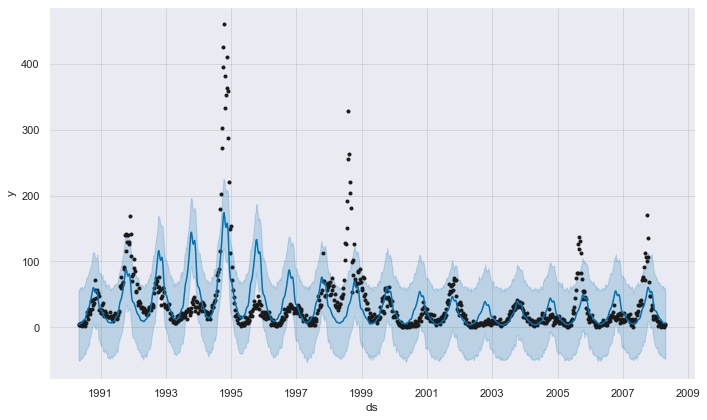

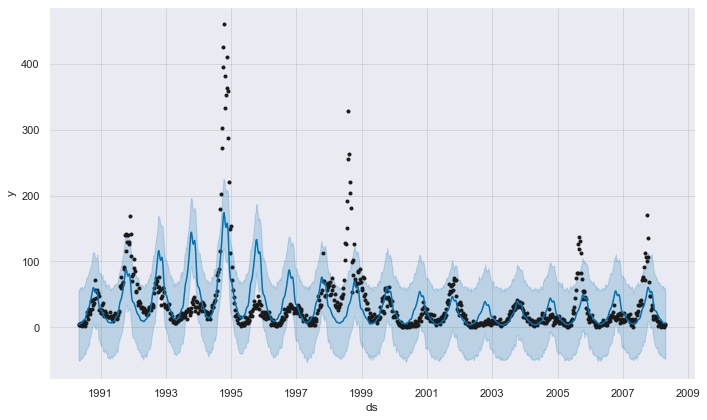

In [10]:
model_sj.fit(train_sj)
forecast_sj = model_sj.predict(train_sj)
model_sj.plot(forecast_sj)

Cross validation

In [11]:
cv_sj = cross_validation(model_sj, horizon = '730 days')
mean_absolute_error(cv_sj['yhat'], cv_sj['y'])

INFO:fbprophet:Making 10 forecasts with cutoffs between 1997-04-25 00:00:00 and 2006-04-23 00:00:00


27.506596137735013

Performs slightly better than previous iteration of prophet

### Iquitos

In [12]:
to_drop = list(train_iq.columns[1:])
train_iq = train_iq.drop(to_drop, axis = 1)
train_iq['y'] = train_labels[train_labels['city'] == 'iq']['total_cases']

In [16]:
model_iq = Prophet(
    growth = 'linear',
    yearly_seasonality = 5,
    weekly_seasonality = False,
    daily_seasonality = False,
    seasonality_mode = 'multiplicative'
)

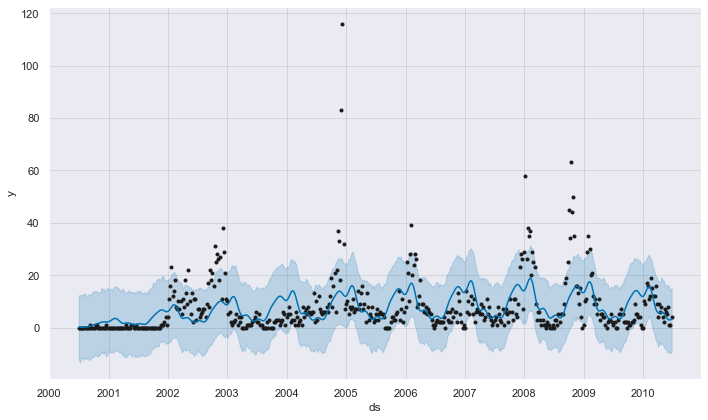

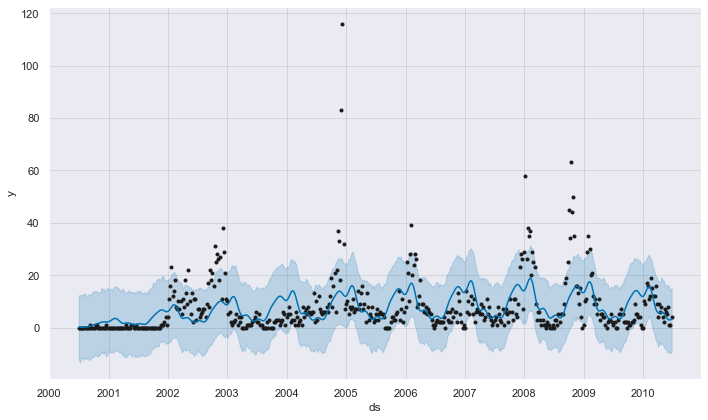

In [17]:
model_iq.fit(train_iq)
forecast_iq = model_iq.predict(train_iq)
model_iq.plot(forecast_iq)

Cross validation

In [18]:
cv_iq = cross_validation(model_iq, horizon = '730 days')
mean_absolute_error(cv_iq['yhat'], cv_iq['y'])

INFO:fbprophet:Making 2 forecasts with cutoffs between 2007-06-26 00:00:00 and 2008-06-25 00:00:00


9.852642902073114

Iquitos performs worse with multiplicative seasonality, so we remove it

NOTE: Setting `seasonality_mode` to additive significantly improved the score. We're down to 26 MAE for San Jose, and

### Making predictions for Driven Data

In [38]:
prophet_basic_sub = pd.read_csv(join(DATA_PATH, 'submission_format.csv'))

San juan

In [31]:
to_drop = list(test_sj.columns[1:])
test_sj = test_sj.drop(to_drop, axis = 1)
forecast_sj = model_sj.predict(test_sj)['yhat'].values

Iquitos

In [33]:
test_iq = test_iq.drop(to_drop, axis = 1)
forecast_iq = model_iq.predict(test_iq)['yhat'].values

In [35]:
y_pred = np.concatenate((forecast_sj, forecast_iq))

In [39]:
prophet_basic_sub['total_cases'] = np.round(y_pred).astype(int)

In [41]:
prophet_basic_sub.to_csv('../models/prophet_basic_sub.csv', index = None)

### Results

25.7 MAE on the leaderboard, a significant improvement over the previous